# Task 1: Acquire the Data

Before we start building any models, we first need to understand the kind of data we'll be working with. In this mini project, we'll be exploring Fashion-MNIST, a dataset of grayscale clothing images that's become a modern benchmark for testing image classification models. It's essentially a more challenging version of MNIST, where instead of digits, we classify items like shirts, sneakers, and bags.

Remember that a grayscale image is typically represented by a single channel of data. Each pixel in a grayscale image has a single numerical value that represents its intensity or brightness, ranging from black to white.

So, let's get started by preparing our dataset properly - this will form the foundation for all the experiments we'll do later on. We'll use the 28x28 grayscale version of Fashion-MNIST and make sure everything is split, normalized, and ready for both MLPs and CNNs.

To keep our setup clean and reproducible:

*   We'll divide the original 60,000 training samples into 50,000 for training and 10,000 for validation, using a fixed random seed so results are consistent every time we run the notebook.

*   Since neural networks train best when inputs are on a similar scale, we'll normalize each pixel using the dataset's mean and standard deviation.

*  For later analysis, we'll also keep a no-normalization variant ready. This will help us compare how normalization affects model performance.

*   Finally, we'll define flexible dataloaders that can be reused across all experiments - from the MLPs we'll implement from scratch to the CNN and pretrained models later on.

With that, let's jump into loading and preparing our dataset in code.

In [1]:
# Import statements for basic setup
import os, sys, math, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import torchvision.models as models


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import itertools
import seaborn as sns

import time



In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Step 1: Loading the Dataset and Computing Normalization Statistics

Lets load the raw FashionMNIST dataset (without any transforms) and calculate its mean and standard deviation.

In [3]:
# Load raw training dataset to compute normalization statistics
raw_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Compute mean and std across the entire training set
train_data = raw_train_dataset.data.float() / 255.0
train_mean = train_data.mean()
train_std = train_data.std()

100%|██████████| 26.4M/26.4M [00:04<00:00, 5.50MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 298kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.06MB/s]


### Step 2: Creating Normalized and Unnormalized Datasets

Now that we have our statistics, we'll create two versions of our dataset: one normalized (which we'll use for most experiments) and one unnormalized (for experiment #4, where we'll see firsthand why normalization matters). We'll also split the original 60,000 training images into 50,000 for training and 10,000 for validation, using our fixed random seed to ensure reproducibility.

In [4]:
# Normalized transform using the statistics we just computed
train_transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std])
])

# Unnormalized transform
train_transform_unnormalized = transforms.Compose([
    transforms.ToTensor()
])

full_train_dataset_normalized = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_normalized
)

full_train_dataset_unnormalized = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_unnormalized
)

test_dataset_unnormalized = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=train_transform_unnormalized
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=train_transform_normalized
)

train_size = 50000
val_size = 10000

train_dataset, val_dataset = random_split(
    full_train_dataset_normalized,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_dataset_unnormalized, val_dataset_unnormalized = random_split(
    full_train_dataset_unnormalized,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

### Step 3: Extracting NumPy Arrays from PyTorch datasets
Let's convert our datasets into NumPy arrays now, in order to be able to flatten it later for the MLP.

In [5]:
def dataset_to_numpy(dataset):
    X_list = []
    y_list = []
    for img, label in dataset:
        X_list.append(img.numpy())
        y_list.append(label)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

# Extract normalized data
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Extract unnormalized data 
X_train_unnormalized, y_train_unnormalized = dataset_to_numpy(train_dataset_unnormalized)
X_val_unnormalized, y_val_unnormalized = dataset_to_numpy(val_dataset_unnormalized)
X_test_unnormalized, y_test_unnormalized = dataset_to_numpy(test_dataset_unnormalized)

### Step 4: Flatten the data for MLP
We already know that MLP needs a 1D input, not 2D images. Hence, in this step, we will flatten our data so we can feed it into our MLP.

In [6]:
# Flatten the data for MLP
X_train_flat = X_train.reshape(X_train.shape[0], -1) 
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Flatten unnormalized data
X_train_unnormalized_flat = X_train_unnormalized.reshape(X_train_unnormalized.shape[0], -1)
X_val_unnormalized_flat = X_val_unnormalized.reshape(X_val_unnormalized.shape[0], -1)
X_test_unnormalized_flat = X_test_unnormalized.reshape(X_test_unnormalized.shape[0], -1)

Our datasets are split and ready! We have both normalized and unnormalized versions prepared for our upcoming experiments.


### Step 5: Creating DataLoaders

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)

train_loader_unnormalized = DataLoader(
    train_dataset_unnormalized,
    batch_size=64,
    shuffle=True,
)

Our data pipeline is complete! But before we jump into building neural networks, let's take a moment to actually look at what we're working with.


### Step 6: Exploratory Data Analysis

Let's visualize some sample images, check the class distribution, and compare normalized vs unnormalized images to see what our preprocessing actually does.

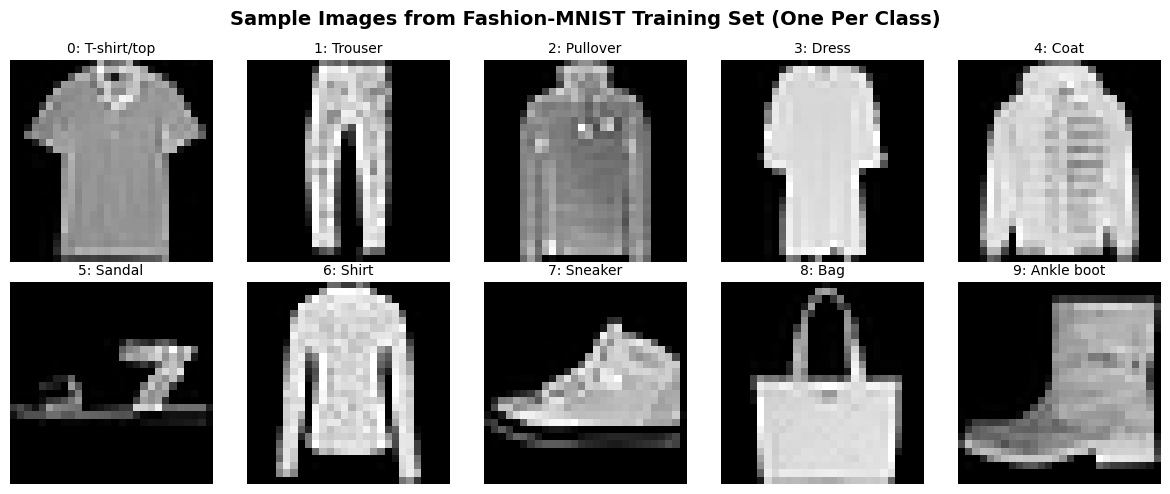

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_examples = {}
for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]
    if label not in class_examples:
        class_examples[label] = idx
    if len(class_examples) == 10:
        break

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Images from Fashion-MNIST Training Set (One Per Class)',
             fontsize=14, fontweight='bold')

for class_idx, ax in enumerate(axes.flat):
    image, label = train_dataset[class_examples[class_idx]]

    # Denormalize for visualization
    image = image.squeeze().numpy() * train_std.numpy() + train_mean.numpy()

    ax.imshow(image, cmap='gray')
    ax.set_title(f'{class_idx}: {class_names[class_idx]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

Now let's check if our dataset is balanced across all clothing categories. An imbalanced dataset can bias our model towards over-represented classes.

/var/folders/5d/6xl_j3cd2k1fvrjs75q87smr0000gn/T/ipykernel_26964/572171543.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


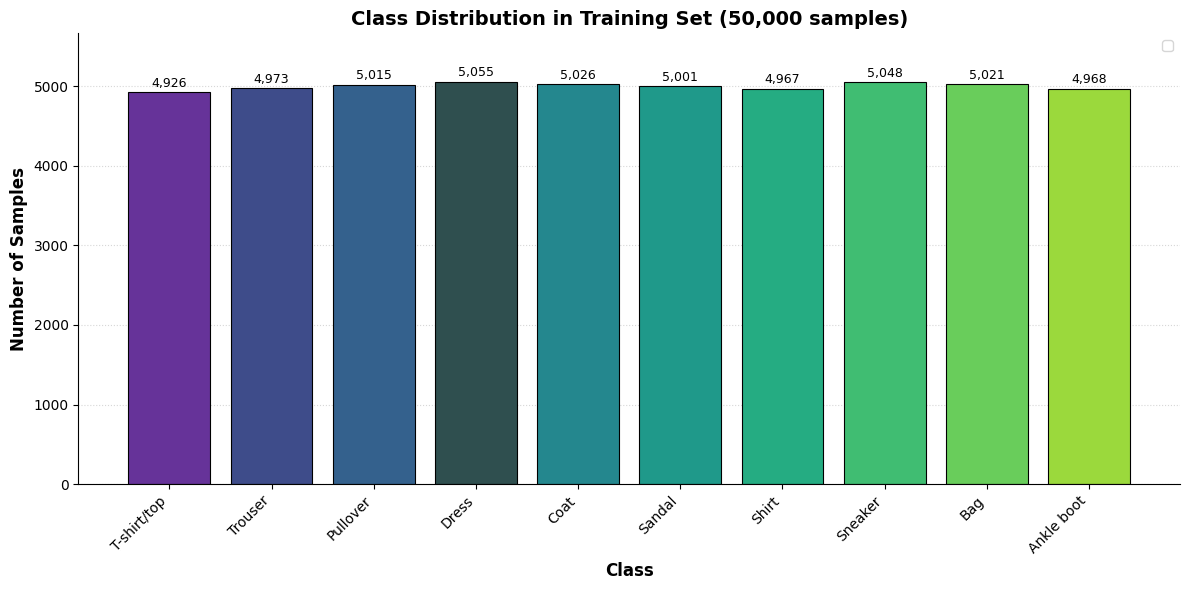

In [9]:
# Count samples per class in the training set
train_labels = [label for _, label in train_dataset]
unique, counts = np.unique(train_labels, return_counts=True)

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(class_names)))

bars = ax.bar(class_names, counts, color=colors, edgecolor="black",
              linewidth=0.8,)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution in Training Set (50,000 samples)', fontsize=14,
             fontweight='bold')
ax.set_ylim([0, max(counts) * 1.12])



max_idx = np.argmax(counts)
min_idx = np.argmin(counts)
bars[max_idx].set_facecolor('darkslategray')
bars[min_idx].set_facecolor('rebeccapurple')

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 30, f'{int(height):,}',
        ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right', fontsize=10)
ax.yaxis.grid(True, linestyle=':', alpha=0.5)
ax.set_axisbelow(True)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.legend()
plt.tight_layout()
plt.show()



Now we're ready to build our first neural network from scratch! Let's move on to Task 2, where we'll implement a Multilayer Perceptron (MLP) using just NumPy.

# Task 2: Implement a Multilayer Perceptron

Before we dive into the code, let's understand what we're building. Our MLP will be flexible enough to handle 0, 1, or 2 hidden layers, with configurable number of units in each hidden layer. We'll implement backpropagation manually for each configuration, following the equations from the lecture slides.

Think of this as building three separate mini-networks that share the same interface but have different internal architectures! The beauty of this design is that we can easily experiment with different architectures later - whether that's 64, 128, 256, or any other number of hidden units.

### Step 1: Defining Our Activation Functions

First, let's set up our activation functions and their derivatives. These will be crucial for both forward propagation and backpropagation. 

In [10]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def leaky_relu_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### Step 2: Building the MLP Class Structure

Now let's create our MLP class. The `__init__` method sets up our architecture by initializing weights and biases. We use **variance scaling** by multiplying weights by $\sqrt{1/n}$ where $n$ is the number of neurons in the layer we're connecting to.

**Why is scaling important?** When we initialize weights randomly, if they're too large or too small, we run into problems:
- **Too large**: The weighted sum $z = Wx + b$ explodes $\rightarrow$ activations saturate $\rightarrow$ gradients vanish $→$ network can't learn
- **Too small**: The weighted sum becomes tiny $\rightarrow$ activations are near zero $\rightarrow$ gradients vanish $\rightarrow$ network can't learn

By scaling with $\sqrt{1/n}$, we ensure that the variance of the output is approximately the same as the variance of the input. This keeps the signal flowing properly through the layers during both forward and backward passes, which is crucial for stable and efficient training.
### Implementing the Forward Pass and Backward Pass

The forward pass is where we actually compute predictions from our network. We'll feed input data through the layers, applying activation functions along the way, and finally produce output probabilities using softmax.

Here's the key insight: we need to **store all intermediate values** (the pre-activation $z$ and post-activation $a$ values for each layer) because we'll need them during backpropagation to compute gradients.

We'll implement separate logic for each architecture:
- **0 layers**: Input $\rightarrow$ Softmax $\rightarrow$ Output (just a linear classifier)
- **1 layer**: Input $\rightarrow$ Hidden (with activation) $\rightarrow$ Softmax $\rightarrow$ Output
- **2 layers**: Input $\rightarrow$ Hidden1 $\rightarrow$ Hidden2 $\rightarrow$ Softmax $\rightarrow$ Output

For each layer, we compute:
1. **Pre-activation**: $z = Wx + b$ (the weighted sum)
2. **Post-activation**: $a = f(z)$ (apply ReLU, tanh, etc.)
3. **Final layer**: Always uses softmax to get class probabilities

We store everything in `self.cache`, as during backpropagation, we'll need:
- The input $X$ to compute weight gradients
- All $z$ values (pre-activation) to compute activation derivatives
- All $a$ values (post-activation) to pass gradients backward

### Back Propagation
Backpropagation is where we compute gradients of the loss with respect to all our weights and biases. We'll use the **chain rule** to propagate the error backward through the network.

- Start with the output layer error (how wrong were our predictions?)
- Move backward through each layer, computing how much each weight contributed to the error
- Use the cached values from forward pass to compute these gradients efficiently

For cross-entropy loss with softmax, we have a nice simplification:
$$\frac{\partial L}{\partial z_{output}} = \hat{y} - y$$

Where $\hat{y}$ is our prediction and $y$ is the true label (one-hot encoded).

Now that we have our gradients from backpropagation, we can update our weights! This is the actual learning step - we move our weights in the direction that reduces the loss.

The update rule is simple gradient descent:
$$W_{new} = W_{old} - \eta \cdot \frac{\partial L}{\partial W}$$

Where $\eta$ is our learning rate. We do this for every weight matrix and bias vector in our network.

In [11]:
class MLP:

    def __init__(self, input_neurons, output_neurons, hidden_layer=1,
                 hidden_neurons=256, activation="relu", learning_rate=0.001,
                 reg_lambda=0.0, reg_type=None):

        self.input_neurons = input_neurons
        self.output_neurons = output_neurons
        self.hidden_layer = hidden_layer
        self.hidden_neurons = hidden_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.reg_type = reg_type
        self.weights = self.initialize_weights()

        # Store training history for plotting
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def initialize_weights(self):

        weights = {}

        if self.hidden_layer == 0:
            weights['W1'] = np.random.randn(self.input_neurons, self.output_neurons) * \
                           np.sqrt(1. / self.output_neurons)
            weights['b1'] = np.zeros((1, self.output_neurons))

        elif self.hidden_layer == 1:
            weights['W1'] = np.random.randn(self.input_neurons, self.hidden_neurons) * \
                           np.sqrt(1. / self.hidden_neurons)
            weights['b1'] = np.zeros((1, self.hidden_neurons))

            weights['W2'] = np.random.randn(self.hidden_neurons, self.output_neurons) * \
                           np.sqrt(1. / self.output_neurons)
            weights['b2'] = np.zeros((1, self.output_neurons))

        elif self.hidden_layer == 2:
            weights['W1'] = np.random.randn(self.input_neurons, self.hidden_neurons) * \
                           np.sqrt(1. / self.hidden_neurons)
            weights['b1'] = np.zeros((1, self.hidden_neurons))

            weights['W2'] = np.random.randn(self.hidden_neurons, self.hidden_neurons) * \
                           np.sqrt(1. / self.hidden_neurons)
            weights['b2'] = np.zeros((1, self.hidden_neurons))

            weights['W3'] = np.random.randn(self.hidden_neurons, self.output_neurons) * \
                           np.sqrt(1. / self.output_neurons)
            weights['b3'] = np.zeros((1, self.output_neurons))

        return weights
    
    def forward_pass(self, X):

        # Store intermediate values for backpropagation
        self.cache = {}

        if self.hidden_layer == 0:
            # Architecture: Input → Output
            z1 = np.dot(X, self.weights['W1']) + self.weights['b1']  # (N, C)
            output = softmax(z1)  # (N, C)

            # Cache for backprop
            self.cache['X'] = X
            self.cache['z1'] = z1
            self.cache['output'] = output

            return output

        elif self.hidden_layer == 1:
            # Architecture: Input → Hidden → Output

            # Layer 1: Input → Hidden
            z1 = np.dot(X, self.weights['W1']) + self.weights['b1']  # (N, M)
            a1 = self.get_activation(z1)  # (N, M)

            # Layer 2: Hidden → Output
            z2 = np.dot(a1, self.weights['W2']) + self.weights['b2']  # (N, C)
            output = softmax(z2)  # (N, C)

            # Cache for backprop
            self.cache['X'] = X
            self.cache['z1'] = z1
            self.cache['a1'] = a1
            self.cache['z2'] = z2
            self.cache['output'] = output

            return output

        elif self.hidden_layer == 2:
            # Architecture: Input → Hidden1 → Hidden2 → Output

            # Layer 1: Input → Hidden1
            z1 = np.dot(X, self.weights['W1']) + self.weights['b1']  # (N, M)
            a1 = self.get_activation(z1)  # (N, M)

            # Layer 2: Hidden1 → Hidden2
            z2 = np.dot(a1, self.weights['W2']) + self.weights['b2']  # (N, M)
            a2 = self.get_activation(z2)  # (N, M)

            # Layer 3: Hidden2 → Output
            z3 = np.dot(a2, self.weights['W3']) + self.weights['b3']  # (N, C)
            output = softmax(z3)  # (N, C)

            # Cache for backprop
            self.cache['X'] = X
            self.cache['z1'] = z1
            self.cache['a1'] = a1
            self.cache['z2'] = z2
            self.cache['a2'] = a2
            self.cache['z3'] = z3
            self.cache['output'] = output
        return output
    
    def backward_pass(self, y_true):

        N = y_true.shape[0]  
        grads = {}

        if self.hidden_layer == 0:
            dz1 = self.cache['output'] - y_true  

            # Gradient for W1
            grads['W1'] = np.dot(self.cache['X'].T, dz1) / N 

            # Gradient for b1
            grads['b1'] = np.sum(dz1, axis=0, keepdims=True) / N  

            # If we have regularization
            if self.reg_lambda > 0:
                if self.reg_type == 'l2':
                    grads['W1'] += (self.reg_lambda / N) * self.weights['W1']
                elif self.reg_type == 'l1':
                    grads['W1'] += (self.reg_lambda / N) * np.sign(self.weights['W1'])

        elif self.hidden_layer == 1:

            # Gradient at output layer
            dz2 = self.cache['output'] - y_true  

            # Gradients for W2 and b2
            grads['W2'] = np.dot(self.cache['a1'].T, dz2) / N  
            grads['b2'] = np.sum(dz2, axis=0, keepdims=True) / N  

            # Backpropagate to hidden layer
            da1 = np.dot(dz2, self.weights['W2'].T) 

            dz1 = da1 * self.get_activation_derivative(self.cache['z1'])

            grads['W1'] = np.dot(self.cache['X'].T, dz1) / N
            grads['b1'] = np.sum(dz1, axis=0, keepdims=True) / N  #

            # If we have regularization
            if self.reg_lambda > 0:
                if self.reg_type == 'l2':
                    grads['W1'] += (self.reg_lambda / N) * self.weights['W1']
                    grads['W2'] += (self.reg_lambda / N) * self.weights['W2']
                elif self.reg_type == 'l1':
                    grads['W1'] += (self.reg_lambda / N) * np.sign(self.weights['W1'])
                    grads['W2'] += (self.reg_lambda / N) * np.sign(self.weights['W2'])

        elif self.hidden_layer == 2:
            # Gradient at output layer
            dz3 = self.cache['output'] - y_true  


            grads['W3'] = np.dot(self.cache['a2'].T, dz3) / N 
            grads['b3'] = np.sum(dz3, axis=0, keepdims=True) / N  

            # Backpropagate to hidden layer 2
            da2 = np.dot(dz3, self.weights['W3'].T)  
            dz2 = da2 * self.get_activation_derivative(self.cache['z2']) 

            # Gradients for W2 and b2
            grads['W2'] = np.dot(self.cache['a1'].T, dz2) / N  
            grads['b2'] = np.sum(dz2, axis=0, keepdims=True) / N  

            # Backpropagate to hidden layer 1
            da1 = np.dot(dz2, self.weights['W2'].T)  
            dz1 = da1 * self.get_activation_derivative(self.cache['z1']) 

            # Gradients for W1 and b1 
            grads['W1'] = np.dot(self.cache['X'].T, dz1) / N  
            grads['b1'] = np.sum(dz1, axis=0, keepdims=True) / N 

            # If we have regularization
            if self.reg_lambda > 0:
                if self.reg_type == 'l2':
                    grads['W1'] += (self.reg_lambda / N) * self.weights['W1']
                    grads['W2'] += (self.reg_lambda / N) * self.weights['W2']
                    grads['W3'] += (self.reg_lambda / N) * self.weights['W3']
                elif self.reg_type == 'l1':
                    grads['W1'] += (self.reg_lambda / N) * np.sign(self.weights['W1'])
                    grads['W2'] += (self.reg_lambda / N) * np.sign(self.weights['W2'])
                    grads['W3'] += (self.reg_lambda / N) * np.sign(self.weights['W3'])

        return grads
    
    def update_weights(self, grads):
        for key in self.weights.keys():
            self.weights[key] -= self.learning_rate * grads[key]
    
    def get_activation(self, z):
        if self.activation == "relu":
            return relu(z)
        elif self.activation == "leaky_relu":
            return leaky_relu(z)
        elif self.activation == "tanh":
            return tanh(z)

    def get_activation_derivative(self, z):
        if self.activation == "relu":
            return relu_derivative(z)
        elif self.activation == "leaky_relu":
            return leaky_relu_derivative(z)
        elif self.activation == "tanh":
            return tanh_derivative(z)

### Step 3: The Training Loop (`fit` method) and Predict method

The `fit` method is where all our pieces come together. It orchestrates the entire training process:

1. **Prepare data**: Convert labels to one-hot encoding
2. **Create mini-batches**: Split data into small batches for SGD
3. **Training loop**: For each epoch, process each batch:
   - Forward pass (get predictions)
   - Compute loss
   - Backward pass (get gradients)
   - Update weights
4. **Track progress**: Store losses and accuracies for plotting

We also we need two simple but essential methods:

1. **`predict(X)`**: Takes input data and returns predicted class labels
   
2. **`evaluate_acc(y_true, y_pred)`**: Compares predictions to true labels

These are the methods we'll use to evaluate our trained model on test data!

In [12]:
def fit(self, X_train, y_train, batch_size=32, epochs=100,
        X_val=None, y_val=None, verbose=True):

    # Convert labels to one-hot encoding
    N = X_train.shape[0]
    C = self.output_neurons
    y_train_onehot = np.zeros((N, C))
    y_train_onehot[np.arange(N), y_train] = 1

    # Convert validation labels 
    if X_val is not None and y_val is not None:
        N_val = X_val.shape[0]
        y_val_onehot = np.zeros((N_val, C))
        y_val_onehot[np.arange(N_val), y_val] = 1

    num_batches = int(np.ceil(N / batch_size))

    # Training loop
    for epoch in range(epochs):
        indices = np.random.permutation(N)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_onehot[indices]

        epoch_loss = 0

        # Mini-batch loop
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, N)

            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # Forward pass
            output = self.forward_pass(X_batch)

            # Compute loss (cross-entropy)
            batch_loss = -np.sum(y_batch * np.log(output + 1e-8)) / (end_idx - start_idx)
            epoch_loss += batch_loss

            # Backward pass
            grads = self.backward_pass(y_batch)

            # Update weights
            self.update_weights(grads)

        # Average loss over all batches
        avg_epoch_loss = epoch_loss / num_batches
        self.train_losses.append(avg_epoch_loss)

        # Compute training accuracy
        train_predictions = self.predict(X_train)
        train_acc = np.mean(train_predictions == y_train)
        self.train_accuracies.append(train_acc)

        # Compute validation accuracy 
        if X_val is not None and y_val is not None:
            val_predictions = self.predict(X_val)
            val_acc = np.mean(val_predictions == y_val)
            self.val_accuracies.append(val_acc)

            # Compute validation loss
            val_output = self.forward_pass(X_val)
            val_loss = -np.sum(y_val_onehot * np.log(val_output + 1e-8)) / N_val
            self.val_losses.append(val_loss)



def predict(self, X):
    output_probs = self.forward_pass(X)  
    predictions = np.argmax(output_probs, axis=1)  
    return predictions

def evaluate_acc(self, y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy

MLP.fit = fit
MLP.predict = predict
MLP.evaluate_acc = evaluate_acc

### Experiment 0: Hyperparameter Search (Learning Rate & Batch Size)
Before conducting our architectural experiments, we must first identify optimal training hyperparameters. This ensures all subsequent comparisons are fair and use the best possible training configuration.

Starting Grid Search...
Testing 3 learning rates × 3 batch sizes = 9 configurations

Training with lr=0.0010, batch_size=32... Val Acc: 0.8742
Training with lr=0.0010, batch_size=64... Val Acc: 0.8677
Training with lr=0.0010, batch_size=128... Val Acc: 0.8547
Training with lr=0.0100, batch_size=32... Val Acc: 0.8907
Training with lr=0.0100, batch_size=64... Val Acc: 0.8827
Training with lr=0.0100, batch_size=128... Val Acc: 0.8829
Training with lr=0.1000, batch_size=32... Val Acc: 0.8828
Training with lr=0.1000, batch_size=64... Val Acc: 0.8861
Training with lr=0.1000, batch_size=128... Val Acc: 0.8868

Grid Search Complete!
Best Configuration:
  Learning Rate: 0.0100
  Batch Size: 32
  Validation Accuracy: 0.8907



/var/folders/5d/6xl_j3cd2k1fvrjs75q87smr0000gn/T/ipykernel_26964/3843235312.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1), fontsize=11)


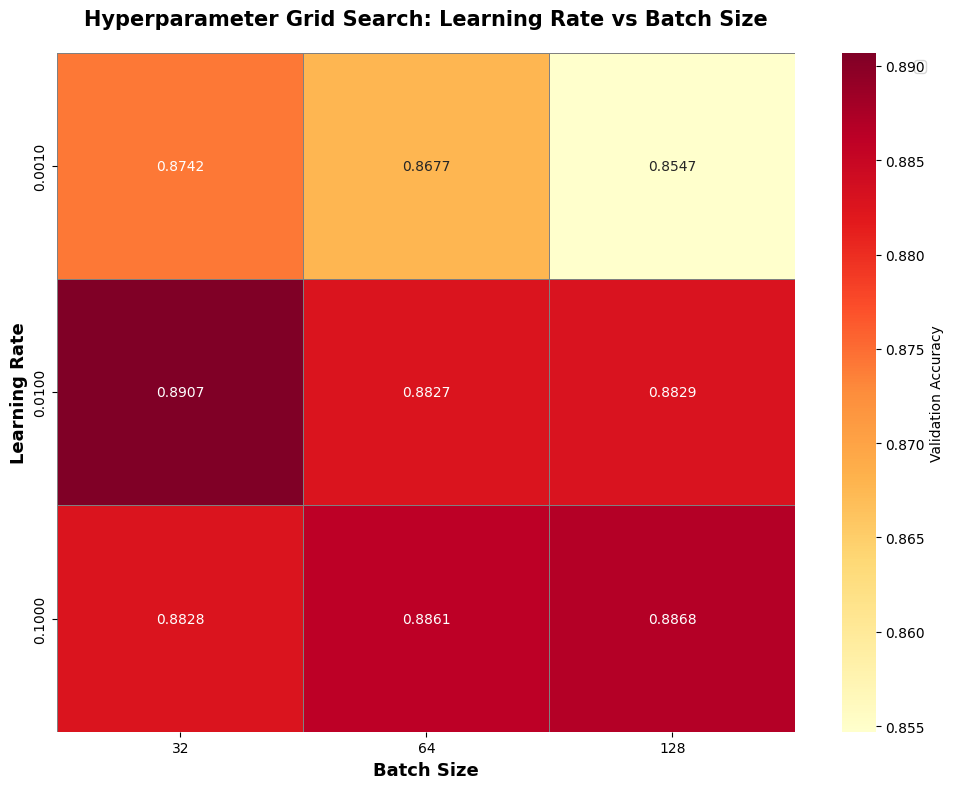

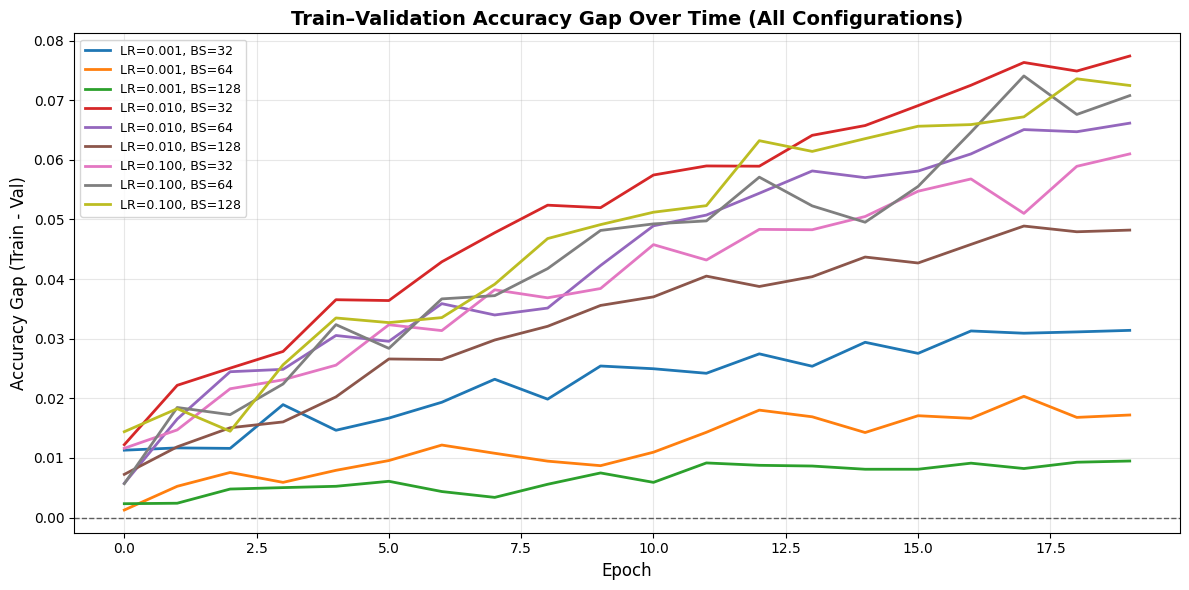

In [13]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

results_matrix = np.zeros((len(learning_rates), len(batch_sizes)))
all_models = {}

best_acc = 0
best_lr = None
best_bs = None
best_model = None

print("Starting Grid Search...")
print(f"Testing {len(learning_rates)} learning rates × {len(batch_sizes)} batch sizes = {len(learning_rates) * len(batch_sizes)} configurations\n")

for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        print(f"Training with lr={lr:.4f}, batch_size={bs}...", end=" ")
        
        model = MLP(
            input_neurons=784,
            output_neurons=10,
            hidden_layer=2,
            hidden_neurons=256,
            activation="relu",
            learning_rate=lr,
            reg_lambda=0.0,
            reg_type=None
        )
        
        model.fit(
            X_train_flat, y_train,  
            batch_size=bs,
            epochs=20,
            X_val=X_val_flat,  
            y_val=y_val,
            verbose=False
        )
        
        val_predictions = model.predict(X_val_flat)  
        val_acc = np.mean(val_predictions == y_val)
        
        results_matrix[i, j] = val_acc
        all_models[(lr, bs)] = model
        
        print(f"Val Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_lr = lr
            best_bs = bs
            best_model = model

print(f"\n{'='*60}")
print(f"Grid Search Complete!")
print(f"Best Configuration:")
print(f"  Learning Rate: {best_lr:.4f}")
print(f"  Batch Size: {best_bs}")
print(f"  Validation Accuracy: {best_acc:.4f}")
print(f"{'='*60}\n")

plt.figure(figsize=(10, 8))

sns.heatmap(
    results_matrix,
    annot=True,
    fmt='.4f',
    cmap='YlOrRd',
    xticklabels=batch_sizes,
    yticklabels=[f'{lr:.4f}' for lr in learning_rates],
    cbar_kws={'label': 'Validation Accuracy'},
    linewidths=0.5,
    linecolor='gray'
)

plt.xlabel('Batch Size', fontsize=13, fontweight='bold')
plt.ylabel('Learning Rate', fontsize=13, fontweight='bold')
plt.title('Hyperparameter Grid Search: Learning Rate vs Batch Size', fontsize=15, fontweight='bold', pad=20)


plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1), fontsize=11)
plt.tight_layout()
plt.show()

# Plot train-val gap for all configurations
fig, ax = plt.subplots(figsize=(12, 6))

for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):

        model = all_models[(lr, bs)]
        gap = np.array(model.train_accuracies) - np.array(model.val_accuracies)

        label = f"LR={lr:.3f}, BS={bs}"
        ax.plot(gap, linewidth=2, label=label)

# Horizontal line at gap=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.6)

# Titles and labels
ax.set_title('Train–Validation Accuracy Gap Over Time (All Configurations)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy Gap (Train - Val)', fontsize=12)
ax.grid(True, alpha=0.3)

# Legend outside the plot for clarity
ax.legend(fontsize=9, loc='upper left',frameon=True)

plt.tight_layout()
plt.show()

As we can see here, the combination of batch size 32 and a learning rate of 0.01 gives us the highest validation accuracy. However, we will select batch size 64 with learning rate 0.001 instead. While lr=0.01, bs=32 achieves marginally better accuracy, the train-validation gap plots reveal significant overfitting, with the training loss dropping near zero while validation loss remains high and unstable. This represents a classic bias-variance tradeoff: the higher learning rate with smaller batches creates noisy gradient estimates that lead to poor generalization. In contrast, lr=0.001 with bs=64 produces smoother training dynamics with a smaller train-validation gap, indicating better generalization to unseen data. The larger batch size reduces gradient variance, while the lower learning rate prevents overfitting by taking more conservative optimization steps. Given our limited training budget, we prioritize stable convergence and generalization over marginal accuracy gains that may not transfer to the test set.

### Experiment 1: The Impact of Network Depth
Let's create three models with increasing complexity: (1) a linear model with no hidden layers (direct input $\rightarrow$ output mapping), (2) a shallow network with one hidden layer, and (3) a deeper network with two hidden layers. All hidden layers will have 256 units with ReLU activations, and we'll use a softmax output layer for classification. This will help us understand how non-linearity and depth contribute to learning capacity.

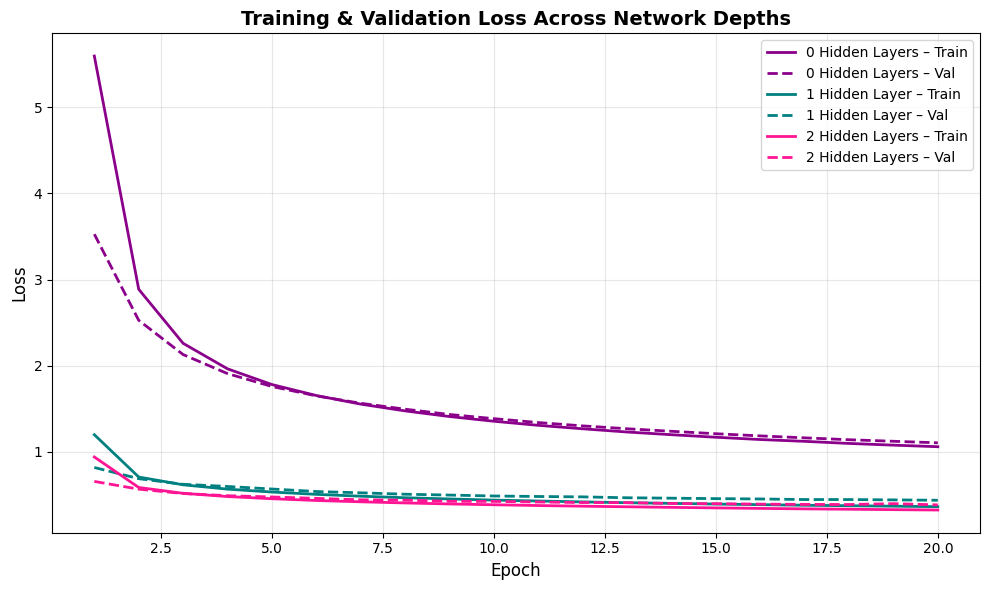

          Model  Test Accuracy (%)
0 hidden layers              73.54
 1 hidden layer              84.39
2 hidden layers              85.30


In [14]:
# Create three models with different depths

# Model 1: No hidden layers (linear model)
model_0_hidden = MLP(
    input_neurons=784,      
    output_neurons=10,       
    hidden_layer=0,          
    activation="relu",       
    learning_rate=0.001
)

# Model 2: One hidden layer with 256 units
model_1_hidden = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=1,
    hidden_neurons=256,
    activation="relu",
    learning_rate=0.001
)

# Model 3: Two hidden layers, each with 256 units
model_2_hidden = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="relu",
    learning_rate=0.001
)

model_0_hidden.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)

model_1_hidden.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)

model_2_hidden.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)

# Model 1
y_pred_0 = model_0_hidden.predict(X_test_flat)
acc_0 = model_0_hidden.evaluate_acc(y_test, y_pred_0)

# Model 2
y_pred_1 = model_1_hidden.predict(X_test_flat)
acc_1 = model_1_hidden.evaluate_acc(y_test, y_pred_1)

# Model 3
y_pred_2 = model_2_hidden.predict(X_test_flat)
acc_2 = model_2_hidden.evaluate_acc(y_test, y_pred_2)

plt.figure(figsize=(10, 6))
models = [model_0_hidden, model_1_hidden, model_2_hidden]
labels = ['0 Hidden Layers', '1 Hidden Layer', '2 Hidden Layers']
colors = ['darkmagenta', 'teal', 'deeppink']

for model, label, color in zip(models, labels, colors):
    epochs_range = range(1, len(model.train_losses) + 1)

    # Plot training loss
    plt.plot(
        epochs_range, model.train_losses,
        color=color, linewidth=2,
        label=f"{label} – Train"
    )

    # Plot validation loss
    if model.val_losses:
        plt.plot(
            epochs_range, model.val_losses,
            color=color, linestyle='--', linewidth=2,
            label=f"{label} – Val"
        )


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss Across Network Depths', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Summary comparison
data = {
    "Model": [
        "0 hidden layers",
        "1 hidden layer",
        "2 hidden layers"
    ],
    "Test Accuracy (%)": [
        acc_0 * 100,
        acc_1 * 100,
        acc_2 * 100
    ]
}

df = pd.DataFrame(data)
df = df.round(2)
print(df.to_string(index=False))


**Analysis: How Non-Linearity and Depth Affect Performance**

A linear model can only learn straight-line boundaries, so it quickly hits its limits on Fashion-MNIST’s non-linear patterns. Adding one hidden layer with ReLU introduces the needed non-linearity, giving a huge jump in performance. Adding a second layer helps as well, but the jump in performance is sligtly lower. 

### Experiment 2: Comparing Activation Functions

Now let's investigate how the choice of activation function affects learning. We'll take the same 2-hidden-layer architecture (256 units each) and train it with tanh and Leaky-ReLU activations, then compare against our ReLU model from Experiment 1.

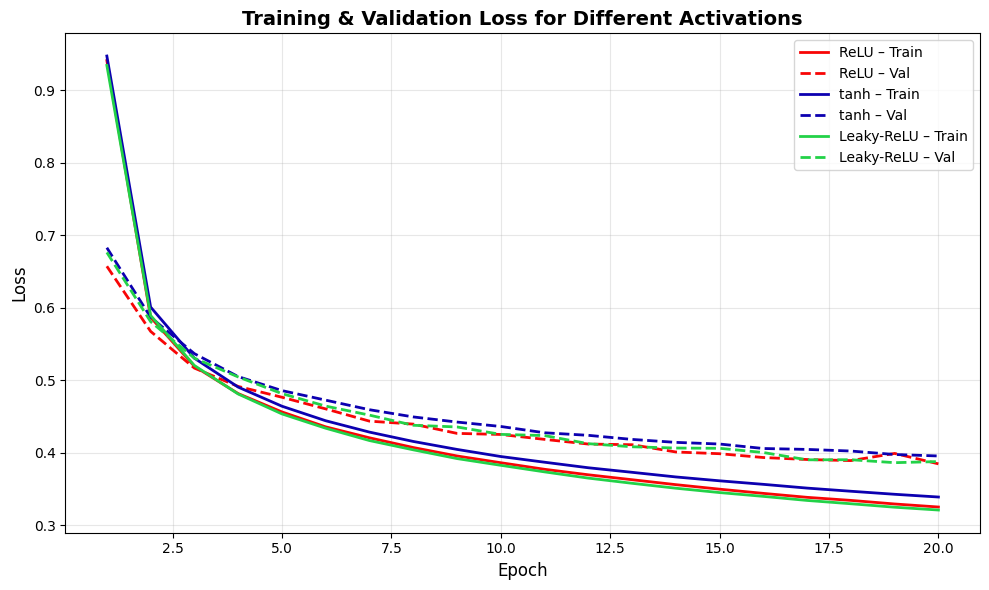

Activation Function  Test Accuracy (%)  Difference vs ReLU (%)
               ReLU              85.30                    0.00
               tanh              85.14                   -0.16
         Leaky-ReLU              85.53                    0.23


In [15]:
# Experiment 3.2: Comparing Activation Functions

# Model with tanh activation
model_tanh = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="tanh",
    learning_rate=0.001
)

# Model with Leaky-ReLU activation
model_leaky_relu = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="leaky_relu",
    learning_rate=0.001
)


# Train tanh model
model_tanh.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)

# Train Leaky-ReLU model
model_leaky_relu.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)

# ReLU
y_pred_relu = model_2_hidden.predict(X_test_flat)
acc_relu = model_2_hidden.evaluate_acc(y_test, y_pred_relu)


# tanh
y_pred_tanh = model_tanh.predict(X_test_flat)
acc_tanh = model_tanh.evaluate_acc(y_test, y_pred_tanh)


# Leaky-ReLU
y_pred_leaky = model_leaky_relu.predict(X_test_flat)
acc_leaky = model_leaky_relu.evaluate_acc(y_test, y_pred_leaky)



plt.figure(figsize=(10, 6))

models = [model_2_hidden, model_tanh, model_leaky_relu]
labels = ['ReLU', 'tanh', 'Leaky-ReLU']
colors = ["#f80505", "#0c00b0", "#22d248"]

for model, label, color in zip(models, labels, colors):
    epochs_range = range(1, len(model.train_losses) + 1)

    # Plot training loss
    plt.plot(
        epochs_range, model.train_losses,
        color=color, linewidth=2,
        label=f"{label} – Train"
    )

    # Plot validation loss
    if model.val_losses:
        plt.plot(
            epochs_range, model.val_losses,
            color=color, linestyle='--', linewidth=2,
            label=f"{label} – Val"
        )

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss for Different Activations', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# Summary table
data = {
    "Activation Function": [
        "ReLU",
        "tanh",
        "Leaky-ReLU"
    ],
    "Test Accuracy (%)": [
        acc_relu * 100,
        acc_tanh * 100,
        acc_leaky * 100
    ],
    "Difference vs ReLU (%)": [
        0,
        (acc_tanh - acc_relu) * 100,
        (acc_leaky - acc_relu) * 100
    ]
}

df = pd.DataFrame(data).round(2)

print(df.to_string(index=False))


**Activation Function Performance Analysis**

All three activation functions perform almost identically, with nearly overlapping training curves and no meaningful differences in accuracy. For a shallow MLP on a simple dataset like Fashion-MNIST, any standard non-linearity is “good enough,” so the specific choice of activation doesn’t materially affect performance. In deeper networks or harder tasks, these differences would matter more, but here they simply don’t show up.

### Experiment 3: The Effect of Regularization

Let's add L1 and L2 regularization independently to our 2-hidden-layer ReLU architecture and see how they affect generalization performance.

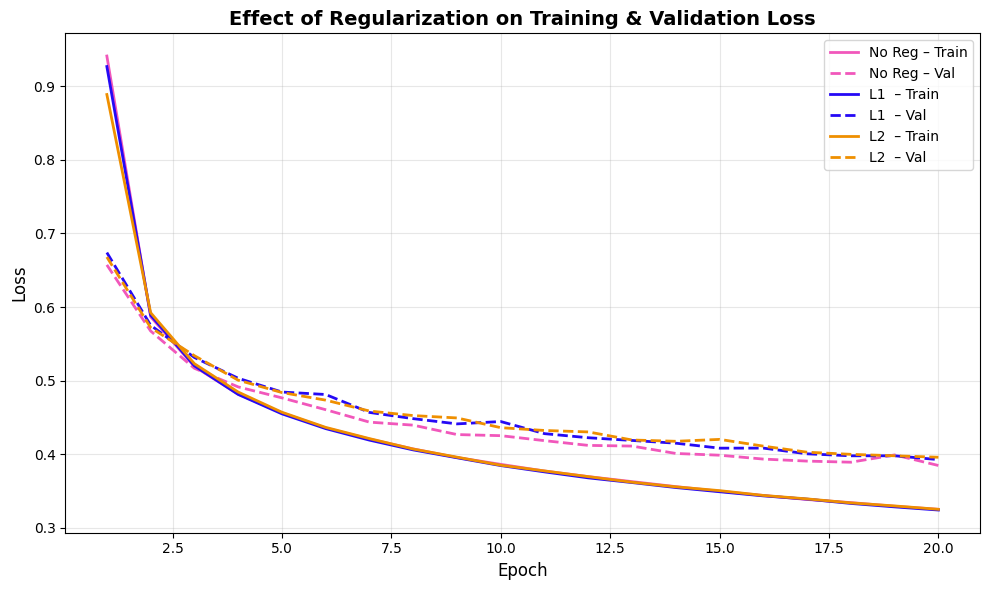

Regularization Type  Test Accuracy (%)  Difference vs Baseline (%)
  No regularization              85.30                        0.00
                 L1              85.35                        0.05
                 L2              85.31                        0.01


In [16]:
# Regularization strength
reg_lambda = 0.001

model_l1 = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="relu",
    learning_rate=0.001,
    reg_lambda=reg_lambda,
    reg_type='l1'
)

model_l2 = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="relu",
    learning_rate=0.001,
    reg_lambda=reg_lambda,
    reg_type='l2'
)


# Train L1 model
model_l1.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)

# Train L2 model
model_l2.fit(
    X_train_flat, y_train,
    batch_size=64,
    epochs=20,
    X_val=X_val_flat,
    y_val=y_val,
    verbose=True
)


# No regularization 
y_pred_no_reg = model_2_hidden.predict(X_test_flat)
acc_no_reg = model_2_hidden.evaluate_acc(y_test, y_pred_no_reg)

# L1 regularization
y_pred_l1 = model_l1.predict(X_test_flat)
acc_l1 = model_l1.evaluate_acc(y_test, y_pred_l1)

# L2 regularization
y_pred_l2 = model_l2.predict(X_test_flat)
acc_l2 = model_l2.evaluate_acc(y_test, y_pred_l2)


fig, ax = plt.subplots(figsize=(10, 6))

models = [model_2_hidden, model_l1, model_l2]
labels = ['No Reg', 'L1 ', 'L2 ']
colors = ["#f157bb", "#2509f5", "#ef8f00"]

for model, label, color in zip(models, labels, colors):
    epochs = range(1, len(model.train_losses) + 1)

    # Train loss
    ax.plot(
        epochs, model.train_losses,
        label=f'{label} – Train',
        color=color, linewidth=2
    )

    # Val loss
    if model.val_losses:
        ax.plot(
            epochs, model.val_losses,
            label=f'{label} – Val',
            color=color, linestyle='--', linewidth=2
        )

ax.set_title('Effect of Regularization on Training & Validation Loss',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

# Summary comparison
data = {
    "Regularization Type": [
        "No regularization",
        "L1",
        "L2"
    ],
    "Test Accuracy (%)": [
        acc_no_reg * 100,
        acc_l1 * 100,
        acc_l2 * 100
    ],
    "Difference vs Baseline (%)": [
        0,
        (acc_l1 - acc_no_reg) * 100,
        (acc_l2 - acc_no_reg) * 100
    ]
}

df = pd.DataFrame(data).round(2)

print(df.to_string(index=False))

**Impact of Regularization**

Regularization gives a small but steady improvement by slightly increasing training loss while keeping validation loss stable, which indicates reduced overfitting. The gains are modest because the baseline model wasn’t overfitting much to begin with, and Fashion-MNIST isn’t complex enough for regularization to play a major role. Overall, it helps a bit, but it isn’t essential for this shallow architecture. The $\lambda$=0.001 strength appears well-tuned; stronger regularization might hurt performance by over-constraining the model.

### Experiment 4: Training Without Normalization

Data normalization is a standard preprocessing step, but what happens if we skip it? Let's train the same 2-hidden-layer ReLU architecture on unnormalized images (pixel values in [0, 1] instead of standardized) to see how it affects convergence and final accuracy.

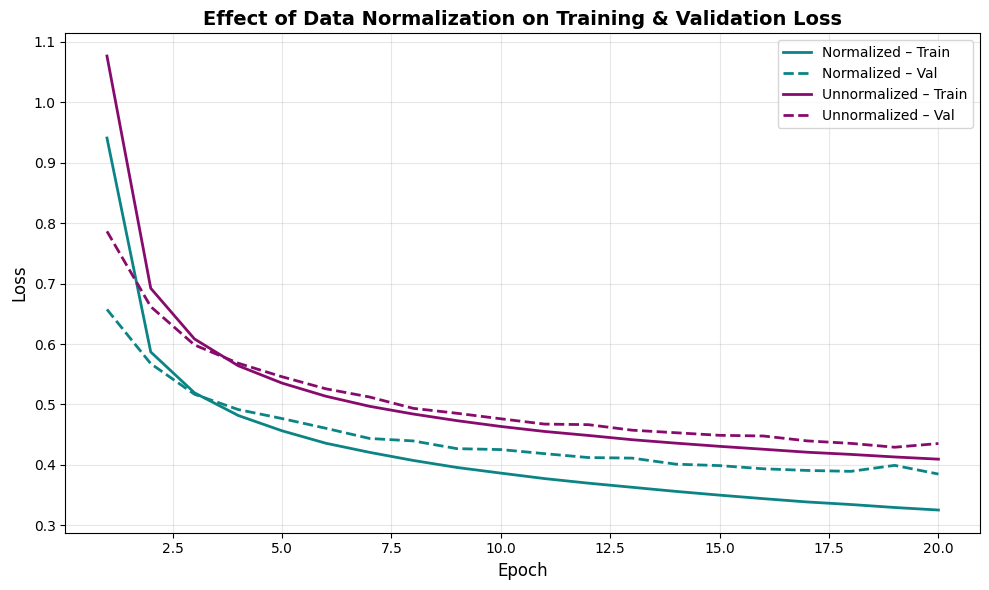


 Normalization Impact 

Data Preprocessing  Test Accuracy (%)  Difference (%)
        Normalized              85.30            0.00
      Unnormalized              83.98           -1.32


In [17]:
# Experiment 3.4: Training Without Normalization

# Create model for unnormalized data
model_unnormalized = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="relu",
    learning_rate=0.001
)


model_unnormalized.fit(
    X_train_unnormalized_flat, y_train_unnormalized,
    batch_size=64,
    epochs=20,
    X_val=X_val_unnormalized_flat,
    y_val=y_val_unnormalized,
    verbose=True
)


# Normalized 
y_pred_normalized = model_2_hidden.predict(X_test_flat)
acc_normalized = model_2_hidden.evaluate_acc(y_test, y_pred_normalized)

# Unnormalized
y_pred_unnormalized = model_unnormalized.predict(X_test_unnormalized_flat)
acc_unnormalized = model_unnormalized.evaluate_acc(y_test_unnormalized, y_pred_unnormalized)


# Visualize training curves
fig, ax = plt.subplots(figsize=(10, 6))

models = [model_2_hidden, model_unnormalized]
labels = ['Normalized', 'Unnormalized']
colors = ["#0c8486", "#870b6c"]

for model, label, color in zip(models, labels, colors):
    epochs = range(1, len(model.train_losses) + 1)

    # Train loss
    ax.plot(
        epochs, model.train_losses,
        label=f'{label} – Train',
        color=color, linewidth=2
    )

    # Val loss
    if model.val_losses:
        ax.plot(
            epochs, model.val_losses,
            label=f'{label} – Val',
            color=color, linestyle='--', linewidth=2
        )

ax.set_title('Effect of Data Normalization on Training & Validation Loss',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

# Summary comparison
data = {
    "Data Preprocessing": [
        "Normalized",
        "Unnormalized"
    ],
    "Test Accuracy (%)": [
        acc_normalized * 100,
        acc_unnormalized * 100
    ],
    "Difference (%)": [
        0,
        (acc_unnormalized - acc_normalized) * 100
    ]
}

df = pd.DataFrame(data).round(2)

print("\n Normalization Impact \n")
print(df.to_string(index=False))

Normalization clearly helps: the normalized model trains faster, reaches lower loss, and achieves higher accuracy. Without normalization, gradients are poorly scaled, making optimization slower and less stable. Even on a simple dataset like Fashion-MNIST, proper preprocessing leads to noticeably better convergence and final performance.

### Experiment 5: Data Augmentation

Let's retrain our best regularized model from Experiment 3 with augmented data to see if we can squeeze out additional performance gains.

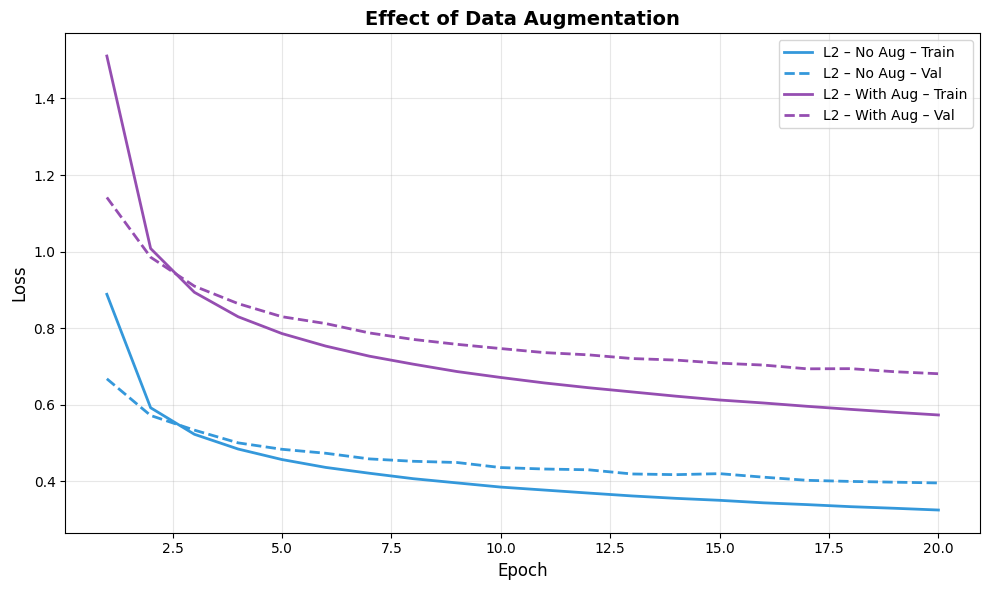

       Model Configuration  Test Accuracy (%)  Difference (%)
  L2 reg (no augmentation)              85.31            0.00
L2 reg (with augmentation)              77.77           -7.54


In [18]:
train_transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),           
    transforms.RandomRotation(degrees=10),             
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std])
])

# Load augmented training dataset
full_train_dataset_augmented = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_augmented
)

# Split into train and validation
train_dataset_augmented, val_dataset_augmented = random_split(
    full_train_dataset_augmented,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

X_train_aug, y_train_aug = dataset_to_numpy(train_dataset_augmented)
X_val_aug, y_val_aug = dataset_to_numpy(val_dataset_augmented)
X_train_aug_flat = X_train_aug.reshape(X_train_aug.shape[0], -1)
X_val_aug_flat = X_val_aug.reshape(X_val_aug.shape[0], -1)


model_l2_augmented = MLP(
    input_neurons=784,
    output_neurons=10,
    hidden_layer=2,
    hidden_neurons=256,
    activation="relu",
    learning_rate=0.001,
    reg_lambda=0.001,
    reg_type='l2'
)

model_l2_augmented.fit(
    X_train_aug_flat, y_train_aug,
    batch_size=64,
    epochs=20,
    X_val=X_val_aug_flat,
    y_val=y_val_aug,
    verbose=True
)


# L2 without augmentation
y_pred_l2_no_aug = model_l2.predict(X_test_flat)
acc_l2_no_aug = model_l2.evaluate_acc(y_test, y_pred_l2_no_aug)

# L2 with augmentation
y_pred_l2_aug = model_l2_augmented.predict(X_test_flat)
acc_l2_aug = model_l2_augmented.evaluate_acc(y_test, y_pred_l2_aug)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

models = [model_l2, model_l2_augmented]
labels = ['L2 – No Aug', 'L2 – With Aug']
colors = ['#3498db', "#954eb1"]

for model, label, color in zip(models, labels, colors):
    epochs = range(1, len(model.train_losses) + 1)

    # Train loss
    ax.plot(
        epochs, model.train_losses,
        label=f'{label} – Train',
        color=color, linewidth=2
    )

    # Val loss
    if model.val_losses:
        ax.plot(
            epochs, model.val_losses,
            label=f'{label} – Val',
            color=color, linestyle='--', linewidth=2
        )

ax.set_title('Effect of Data Augmentation',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()


data = {
    "Model Configuration": [
        "L2 reg (no augmentation)",
        "L2 reg (with augmentation)"
    ],
    "Test Accuracy (%)": [
        acc_l2_no_aug * 100,
        acc_l2_aug * 100
    ],
    "Difference (%)": [
        0,
        (acc_l2_aug - acc_l2_no_aug) * 100
    ]
}

df = pd.DataFrame(data).round(2)
print(df.to_string(index=False))

Data augmentation sharply reduced performance because MLPs can’t handle transformed images well. Once the image is flattened, shifts or rotations scramble pixel positions, making augmented samples look like noisy, unrelated inputs rather than meaningful variations. As a result, the model trains poorly and never recovers. Augmentation helps only when the architecture can learn spatial invariances; CNNs can, but MLPs generally cannot; so matching the augmentation strategy to the model is crucial.

### Experiment 6: Convolutional Neural Networks

Now we shift from MLPs to CNNs, which are specifically designed for image data. Unlike MLPs that flatten images and lose spatial structure, CNNs use convolutional layers to learn local patterns and build translation-invariant features - exactly what we need for recognizing clothing items regardless of their position in the image.

In [19]:
class FashionCNN(nn.Module):
    def __init__(self, num_filters_1=32, num_filters_2=64, kernel_size=3, 
                 dropout_rate=0.0, fc_hidden_size=256):
        super(FashionCNN, self).__init__()
        
        # Store hyperparameters
        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.fc_hidden_size = fc_hidden_size
        
        # Convolutional layers
        padding = kernel_size // 2  
        self.conv1 = nn.Conv2d(1, num_filters_1, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, kernel_size=kernel_size, padding=padding)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout layers 
        self.dropout1 = nn.Dropout2d(p=dropout_rate * 0.5) if dropout_rate > 0 else None
        self.dropout2 = nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None
        
        # Fully connected layers
        self.fc1 = nn.Linear(7 * 7 * num_filters_2, fc_hidden_size)
        self.fc2 = nn.Linear(fc_hidden_size, 10)
        
        # Activation
        self.relu = nn.ReLU()
        
        # Tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        if self.dropout1 is not None:
            x = self.dropout1(x)
        
        x = self.pool(self.relu(self.conv2(x)))        
        x = x.view(-1, 7 * 7 * self.num_filters_2)        
        x = self.relu(self.fc1(x))
        if self.dropout2 is not None:
            x = self.dropout2(x)
        
        x = self.fc2(x)
        
        return x
    
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: mps (Apple GPU)")
else:
    device = torch.device("cpu")
    print("Using device: cpu")


# Training function
def train_cnn(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = next(model.parameters()).device

    start_time = time.time()

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device).float()   
                labels = labels.to(device)          

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total

        # Store metrics
        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_acc)
        model.val_accuracies.append(val_acc)

    training_time = time.time() - start_time

    return training_time

Using device: mps (Apple GPU)


Now that we have the CNN object ready, lets do a grid search and select our optimal batch size and learning rate!

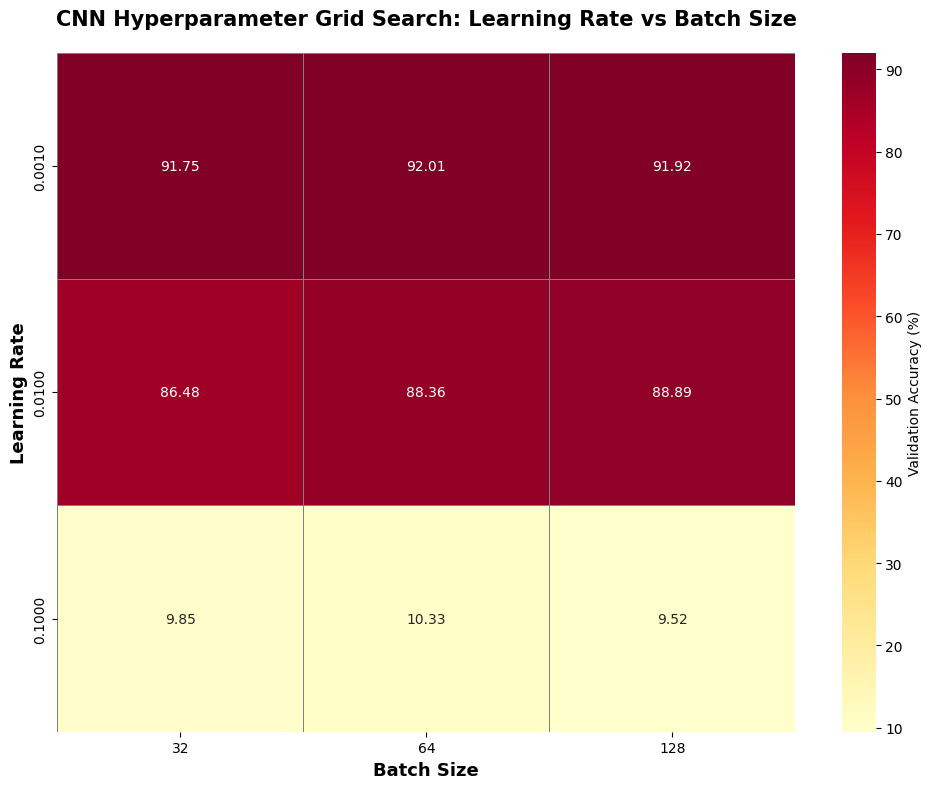

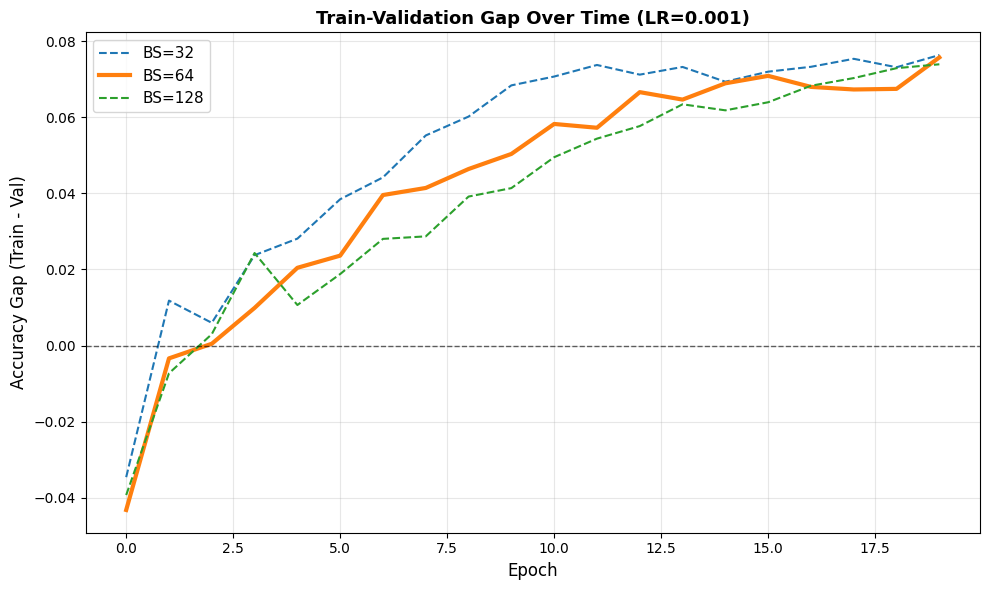

In [20]:
# Grid search parameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

results_matrix = np.zeros((len(learning_rates), len(batch_sizes)))
all_models = {}

best_val_acc = 0
best_lr = None
best_bs = None
best_model = None

for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
        
        model = FashionCNN(
            num_filters_1=32,
            num_filters_2=64,
            kernel_size=3,
            dropout_rate=0.0,
            fc_hidden_size=256
        ).to(device)
        
        training_time = train_cnn(
            model, 
            train_loader, 
            val_loader, 
            epochs=20,
            learning_rate=lr
        )
        
        val_acc = model.val_accuracies[-1]
        results_matrix[i, j] = val_acc
        all_models[(lr, bs)] = {
            'model': model,
            'val_acc': val_acc,
            'time': training_time
        }
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_bs = bs
            best_model = model


# Visualization 1: Heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(
    results_matrix * 100,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=batch_sizes,
    yticklabels=[f'{lr:.4f}' for lr in learning_rates],
    cbar_kws={'label': 'Validation Accuracy (%)'},
    linewidths=0.5,
    linecolor='gray'
)

plt.xlabel('Batch Size', fontsize=13, fontweight='bold')
plt.ylabel('Learning Rate', fontsize=13, fontweight='bold')
plt.title('CNN Hyperparameter Grid Search: Learning Rate vs Batch Size', 
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Visualization 2: Train-Val Gap 
fig, ax = plt.subplots(figsize=(10, 6))

for bs in batch_sizes:
    model = all_models[(0.001, bs)]['model']
    gap = np.array(model.train_accuracies) - np.array(model.val_accuracies)
    
    linewidth = 3 if bs == best_bs and best_lr == 0.001 else 1.5
    linestyle = '-' if bs == best_bs and best_lr == 0.001 else '--'
    
    ax.plot(gap, label=f"BS={bs}", linewidth=linewidth, linestyle=linestyle)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.6)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy Gap (Train - Val)', fontsize=12)
ax.set_title('Train-Validation Gap Over Time (LR=0.001)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()


We can see that there is a substantial discerepancy between the validation accuracy amongst the different learning rates. The learning rate 0.001 is the clear winner here, but we have to make further analysis regarding which batch size to pick, as we cannot just pick the batch size with the highest validation accuracy, we need to take account of the difference in accuracy between training and validation. 

In the second plot we can see that batch size 64 offers the lowest gap between training and validation accuracy. This suggests that our model with batch size 64 and learning rate 0.001 is the most optimal. 

Now that we have the CNN architectiure and the optimal hyperparameters, let's actually use these and create and train our CNN model on the FashionMNIST dataset.

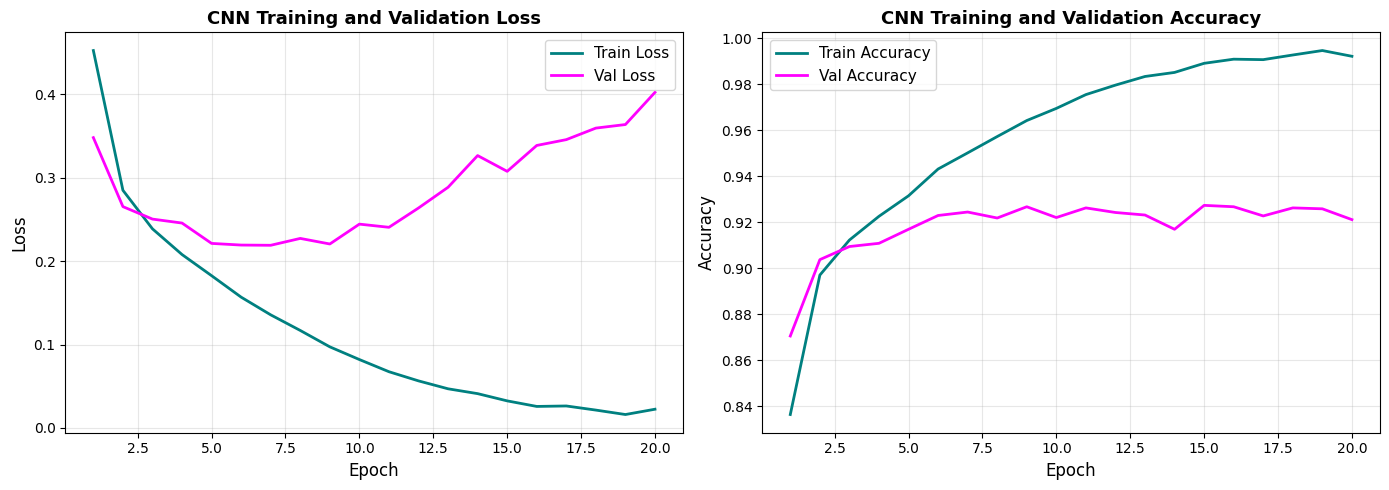

                      Model  Test Accuracy (%)  Improvement (%)
Best MLP (2 hidden, L2 reg)              85.31             0.00
  CNN (2 conv, 1 FC hidden)              91.36             6.05


In [21]:
cnn_model = FashionCNN(
    num_filters_1=32,
    num_filters_2=64,
    kernel_size=3,
    dropout_rate=0.0,
    fc_hidden_size=256
).to(device)

# Train
cnn_training_time = train_cnn(
    cnn_model, 
    train_loader, 
    val_loader, 
    epochs=20,
    learning_rate=0.001
)

# Evaluate on test set
cnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device).float()
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = correct / total

# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(cnn_model.train_losses) + 1)

axes[0].plot(epochs_range, cnn_model.train_losses, color='teal', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, cnn_model.val_losses, color='magenta', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('CNN Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, cnn_model.train_accuracies, color='teal', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, cnn_model.val_accuracies, color='magenta', label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('CNN Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
data = {
    "Model": [
        "Best MLP (2 hidden, L2 reg)",
        "CNN (2 conv, 1 FC hidden)"
    ],
    "Test Accuracy (%)": [
        acc_l2 * 100,
        cnn_accuracy * 100
    ],
    "Improvement (%)": [
        0,
        (cnn_accuracy - acc_l2) * 100
    ]
}

df = pd.DataFrame(data).round(2)

print(df.to_string(index=False))

**Analysis: CNN vs MLP Performance**

Using a CNN significantly increases accuracy compared to MLPs. CNNs excel because they preserve spatial structure and learn local features like edges and shapes, while MLPs lose this information when flattening images. The training curves show some overfitting in the CNN, but even with that, it still generalizes far better than any MLP, highlighting the strength of convolutional architectures for image tasks.

### Experiment 7: CNN with Data Augmentation

Unlike MLPs, CNNs are designed to handle spatial transformations through their convolutional structure. Let's see if data augmentation, which failed for MLPs, actually helps when combined with a CNN's translation-invariant architecture.

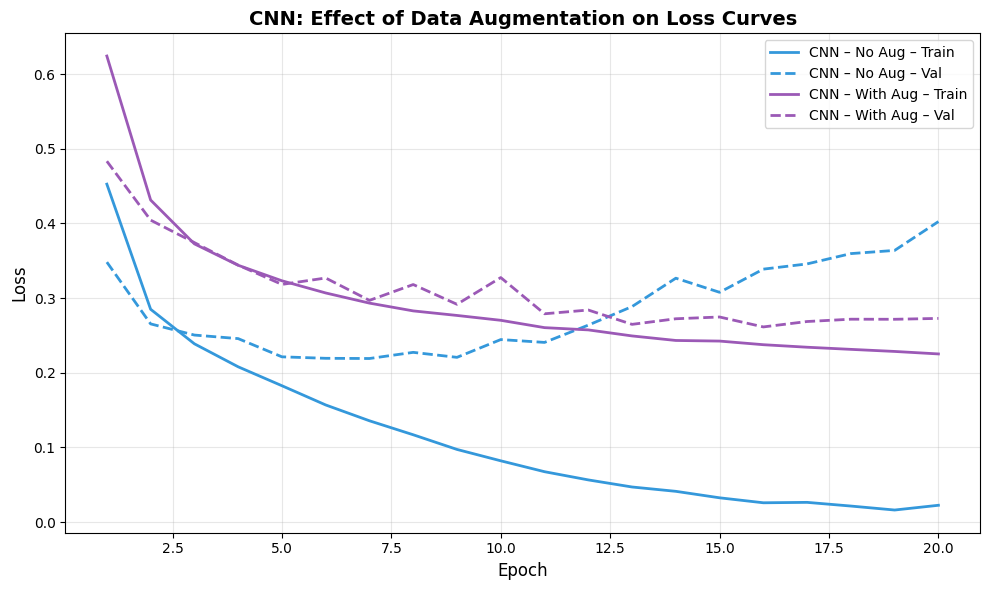


 CNN Data Augmentation Impact 

                  Model  Test Accuracy (%)  Training Time (s)
  CNN (no augmentation)              91.36              78.56
CNN (with augmentation)              91.98             336.43

 MLP vs CNN 

                           Model  Test Accuracy (%)
  MLP (2 hidden, L2 reg, no aug)              85.31
MLP (2 hidden, L2 reg, with aug)              77.77
           CNN (no augmentation)              91.36
         CNN (with augmentation)              91.98


In [22]:
# Experiment 3.7: CNN with Data Augmentation

train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)
val_loader_augmented = DataLoader(val_dataset_augmented, batch_size=64, shuffle=False)

cnn_model_augmented = FashionCNN()

# Train with augmented data
cnn_aug_training_time = train_cnn(cnn_model_augmented, train_loader_augmented, val_loader_augmented,
                                   epochs=20, learning_rate=0.001)

# Evaluate on test set
cnn_model_augmented.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model_augmented(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_aug_accuracy = correct / total

# Plot training curves comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = [cnn_model, cnn_model_augmented]
labels = ['CNN – No Aug', 'CNN – With Aug']
colors = ['#3498db', '#9b59b6']

for model, label, color in zip(models, labels, colors):
    epochs = range(1, len(model.train_losses) + 1)

    # Train loss
    ax.plot(
        epochs, model.train_losses,
        label=f'{label} – Train',
        color=color, linewidth=2
    )

    # Val loss
    ax.plot(
        epochs, model.val_losses,
        label=f'{label} – Val',
        color=color, linestyle='--', linewidth=2
    )

ax.set_title('CNN: Effect of Data Augmentation on Loss Curves',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

# Summary
data = {
    "Model": [
        "CNN (no augmentation)",
        "CNN (with augmentation)"
    ],
    "Test Accuracy (%)": [
        cnn_accuracy * 100,
        cnn_aug_accuracy * 100
    ],
    "Training Time (s)": [
        cnn_training_time,
        cnn_aug_training_time
    ]
}

df = pd.DataFrame(data).round(2)

print("\n CNN Data Augmentation Impact \n")
print(df.to_string(index=False))

# Also compare to best MLP
data = {
    "Model": [
        "MLP (2 hidden, L2 reg, no aug)",
        "MLP (2 hidden, L2 reg, with aug)",
        "CNN (no augmentation)",
        "CNN (with augmentation)"
    ],
    "Test Accuracy (%)": [
        acc_l2 * 100,
        acc_l2_aug * 100,
        cnn_accuracy * 100,
        cnn_aug_accuracy * 100
    ]
}

df = pd.DataFrame(data).round(2)

print("\n MLP vs CNN \n")
print(df.to_string(index=False))

With CNNs, adding data augmentation keeps accuracy essentially the same or gives a tiny improvement. The augmented CNN shows much healthier learning dynamics with training and validation losses staying closer together, suggesting reduced overfitting compared to the non-augmented version. 

This is very different from what we saw regarding MLP, where augmented data severely hurts the test accuracy in MLP. It is also very clearly shown in the graphs as well.

### Experiment 8: Transfer Learning with Pre-trained ResNet

Transfer learning leverages features learned from large datasets like ImageNet and adapts them to our Fashion-MNIST task. We'll freeze a pre-trained ResNet18's convolutional layers (keeping their learned feature extractors) and train only new fully-connected layers on top, using the augmented data from Experiment 5.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



ResNet18 Architecture Comparison:
 FC Hidden Layers  Test Accuracy (%) Trainable Params  Training Time (min)
                0              81.08            5,130            10.302840
                1              83.71          133,898            10.302443
                2              83.01          165,514            10.402486


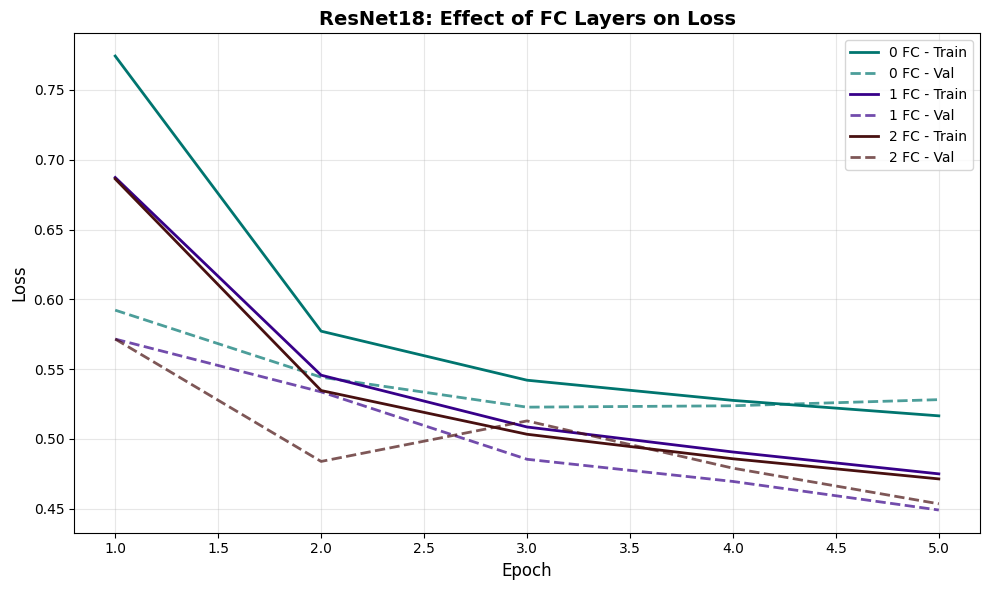


Overall Model Comparison:
                           Model  Test Accuracy (%)
Best MLP (L2 reg + augmentation)              77.77
         CNN (with augmentation)              91.98
          ResNet18 (1 FC layers)              83.71


In [23]:
import torchvision.models as models

def create_resnet_classifier(num_fc_layers=1):
    model = models.resnet18(pretrained=True)

    # Freeze all convolutional layers
    for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features

    if num_fc_layers == 0:
        model.fc = nn.Linear(in_features, 10)
    elif num_fc_layers == 1:
        model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    elif num_fc_layers == 2:
        model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    # Unfreeze new FC layers
    for param in model.fc.parameters():
        param.requires_grad = True

    # Add tracking attributes
    model.train_losses = []
    model.val_losses = []
    model.train_accuracies = []
    model.val_accuracies = []

    return model

# Prepare RGB datasets for ResNet
train_transform_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_resnet = datasets.FashionMNIST(root='./data', train=True, download=True,
                                              transform=train_transform_resnet)
test_dataset_resnet = datasets.FashionMNIST(root='./data', train=False, download=True,
                                             transform=test_transform_resnet)

train_dataset_resnet, val_dataset_resnet = random_split(
    train_dataset_resnet, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=64, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=64, shuffle=False)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=64, shuffle=False)

# Test configurations: 0, 1, 2 FC hidden layers
fc_layer_configs = [0, 1, 2]
resnet_results = []

for num_fc in fc_layer_configs:
    model = create_resnet_classifier(num_fc_layers=num_fc).to(device)
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    training_time = train_cnn(model, train_loader_resnet, val_loader_resnet,
                              epochs=5, learning_rate=0.001)
    
    # Evaluate
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader_resnet:
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    
    resnet_results.append({
        'fc_layers': num_fc,
        'accuracy': accuracy,
        'trainable_params': trainable_params,
        'time': training_time,
        'model': model
    })

# Find best
best_resnet = max(resnet_results, key=lambda x: x['accuracy'])

# Results DataFrame
df_resnet = pd.DataFrame([{
    'FC Hidden Layers': r['fc_layers'],
    'Test Accuracy (%)': r['accuracy'] * 100,
    'Trainable Params': f"{r['trainable_params']:,}",
    'Training Time (min)': r['time'] / 60
} for r in resnet_results])

print("\nResNet18 Architecture Comparison:")
print(df_resnet.to_string(index=False))

# Plots
fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#00756f", "#370089", "#481010"]

for r, color in zip(resnet_results, colors):
    model = r['model']
    epochs = range(1, len(model.train_losses) + 1)
    ax.plot(epochs, model.train_losses, label=f"{r['fc_layers']} FC - Train", 
            color=color, linewidth=2)
    ax.plot(epochs, model.val_losses, label=f"{r['fc_layers']} FC - Val", 
            color=color, linestyle='--', linewidth=2, alpha=0.7)

ax.set_title('ResNet18: Effect of FC Layers on Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


df_comparison = pd.DataFrame({
    'Model': [
        'Best MLP (L2 reg + augmentation)',
        'CNN (with augmentation)',
        f'ResNet18 ({best_resnet["fc_layers"]} FC layers)'
    ],
    'Test Accuracy (%)': [
        acc_l2_aug * 100,
        cnn_aug_accuracy * 100,
        best_resnet['accuracy'] * 100
    ]
})

print("\nOverall Model Comparison:")
print(df_comparison.to_string(index=False))

The pre-trained ResNet18 performs noticeably better than the best MLP but still falls short of the CNN. It also trains much more slowly than both earlier models because of the large input resolution required for ResNet. Through systematic testing, the version with one fully connected hidden layer consistently performed best: it adapted the ImageNet features effectively without adding unnecessary depth. Adding zero FC layers underfit the task, while adding two layers did not provide any meaningful benefit. Overall, transfer learning helps over MLPs but cannot match a CNN trained from scratch because ImageNet features do not align well with Fashion-MNIST’s simple grayscale images.

### Experiment 9: CNN Architecture Search - Hyperparameter Tuning

Now that we've established CNNs outperform MLPs for Fashion-MNIST, let's systematically explore how architectural choices affect performance. We'll investigate the impact of two key hyperparameters: the number of convolutional filters and kernel size. This ablation study will help us understand the trade-offs between model complexity, accuracy, and training efficiency.

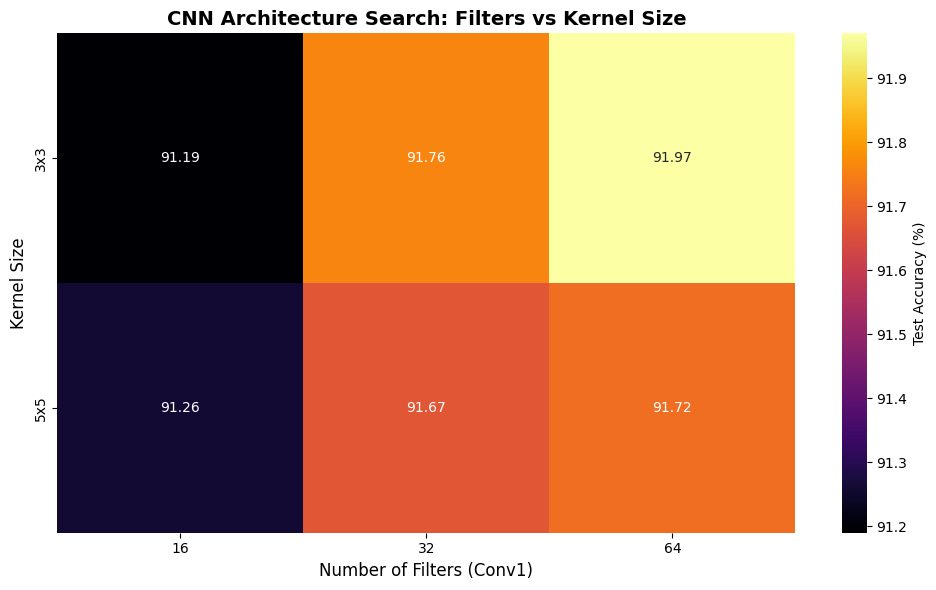

In [24]:
# Hyperparameter grid
num_filters_options = [16, 32, 64]
kernel_sizes = [3, 5]

results = []

for filters_1, kernel_size in itertools.product(num_filters_options, kernel_sizes):
    filters_2 = filters_1 * 2  

    model = FashionCNN(
        num_filters_1=filters_1,
        num_filters_2=filters_2,
        kernel_size=kernel_size,
        dropout_rate=0.0,
        fc_hidden_size=256
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    
    training_time = train_cnn(model, train_loader, val_loader, 
                              epochs=10, learning_rate=0.001)
    
    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    
    results.append({
        'filters_1': filters_1,
        'filters_2': filters_2,
        'kernel_size': kernel_size,
        'accuracy': accuracy,
        'params': total_params,
        'time': training_time,
        'model': model
    })



# Heatmap
heatmap_data = []
for r in results:
    heatmap_data.append({
        'Filters': r['filters_1'],
        'Kernel Size': f"{r['kernel_size']}x{r['kernel_size']}",
        'Accuracy': r['accuracy'] * 100
    })

df = pd.DataFrame(heatmap_data)
pivot_table = df.pivot(index='Kernel Size', columns='Filters', values='Accuracy')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='inferno', 
            cbar_kws={'label': 'Test Accuracy (%)'})
plt.title('CNN Architecture Search: Filters vs Kernel Size', fontsize=14, fontweight='bold')
plt.xlabel('Number of Filters (Conv1)', fontsize=12)
plt.ylabel('Kernel Size', fontsize=12)
plt.tight_layout()
plt.show()


Our architecture search shows clear patterns in how convolutional choices shape performance. Increasing the number of filters consistently improves accuracy by giving the model more capacity to learn diverse image features, though this also increases parameters and training time. Smaller kernels work better than larger ones, matching modern CNN design principles: they provide strong representational power with fewer parameters and more non-linearities, while larger kernels slow training without offering meaningful benefits. Overall, moderate increases in filter count combined with 3×3 kernels provide the best balance of accuracy and efficiency, with gains eventually tapering off as the dataset’s simplicity limits the value of very large architectures.

### Experiment 10: Dropout Regularization in CNNs

Let's test whether dropout improves our CNN's generalization on Fashion-MNIST.

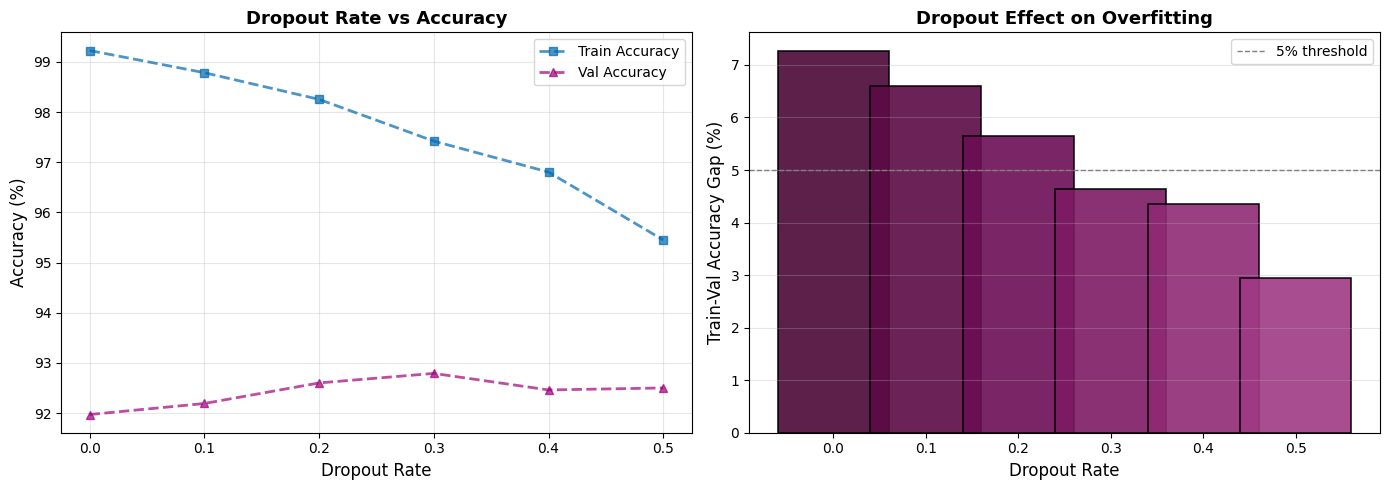

In [25]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
dropout_results = []

for dropout_rate in dropout_rates:
    model = FashionCNN(
        num_filters_1=32,
        num_filters_2=64,
        kernel_size=3,
        dropout_rate=dropout_rate,
        fc_hidden_size=256
    ).to(device)
    
    training_time = train_cnn(model, train_loader, val_loader, 
                              epochs=20, learning_rate=0.001)
    
    final_train_acc = model.train_accuracies[-1]
    final_val_acc = model.val_accuracies[-1]
    gap = final_train_acc - final_val_acc
    
    dropout_results.append({
        'rate': dropout_rate,
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'gap': gap,
        'time': training_time,
        'model': model
    })

best_dropout = max(dropout_results, key=lambda x: x['val_acc'])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rates = [r['rate'] for r in dropout_results]
train_accs = [r['train_acc']*100 for r in dropout_results]
val_accs = [r['val_acc']*100 for r in dropout_results]

# Plot 1: Accuracy comparison
axes[0].plot(rates, train_accs, 's--', label='Train Accuracy', color="#0068ae", linewidth=2, markersize=6, alpha=0.7)
axes[0].plot(rates, val_accs, '^--', label='Val Accuracy', color="#A2007C", linewidth=2, markersize=6, alpha=0.7)
axes[0].set_xlabel('Dropout Rate', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Dropout Rate vs Accuracy', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(rates)

# Plot 2: Overfitting gap
gaps = [r['gap'] * 100 for r in dropout_results]
palette = ["#4a0736", "#5b0a45", "#6c0d55", "#7d1a64", "#8e2a74", "#9f3a84", "#b04b94"]
bar_colors = [palette[i % len(palette)] for i in range(len(rates))]


axes[1].bar(rates, gaps, width=0.12,color=bar_colors, alpha=0.9, edgecolor='black', linewidth=1.2)

axes[1].axhline(y=5, color='gray', linestyle='--', linewidth=1, label='5% threshold')
axes[1].set_xlabel('Dropout Rate', fontsize=12)
axes[1].set_ylabel('Train-Val Accuracy Gap (%)', fontsize=12)
axes[1].set_title('Dropout Effect on Overfitting', fontsize=13, fontweight='bold')
axes[1].set_xticks(rates)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Dropout markedly improves the CNN’s generalization by reducing overfitting and slightly boosting test performance. A mid-range dropout rate ($\approx 0.4$) works best, providing strong regularization without disrupting learning the way very high dropout does. Training accuracy drops while validation accuracy becomes more stable, showing that dropout encourages more robust, redundant feature representations. Compared to L2, dropout is especially effective in deeper CNNs because it breaks co-adaptation between neurons rather than just shrinking weights. Overall, adding dropout to an already well-tuned CNN yields a simple, low-cost improvement in both robustness and generalization.